In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
plt.rcParams['figure.figsize']= (20,8)

We perform some data augmentation steps such as rotation, shearing, change in brightness, etc. This will help us with a more generalised model

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pushpalama/grape-disease")

print("Path to dataset files:", path)

100%|██████████| 151M/151M [00:01<00:00, 137MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pushpalama/grape-disease/versions/1


In [ ]:
import os

# Chemin d'extraction du dataset
dataset_path = "/root/.cache/kagglehub/datasets/pushpalama/grape-disease/versions/1"
print("Fichiers extraits :")
print(os.listdir(dataset_path))


Fichiers extraits :
['grape_dataset']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = 224

datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    validation_split=0.15,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    brightness_range=[0.6, 1.2]
)

# Chemins ajustés pour le dataset
train_dir = os.path.join(dataset_path, "grape_dataset/train")
test_dir = os.path.join(dataset_path, "grape_dataset/test")

# Train Generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    shuffle=True,
    class_mode='categorical'
)

# Validation Generator
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    class_mode='categorical'
)

# Test Generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)


Found 6140 images belonging to 4 classes.
Found 1082 images belonging to 4 classes.
Found 1805 images belonging to 4 classes.


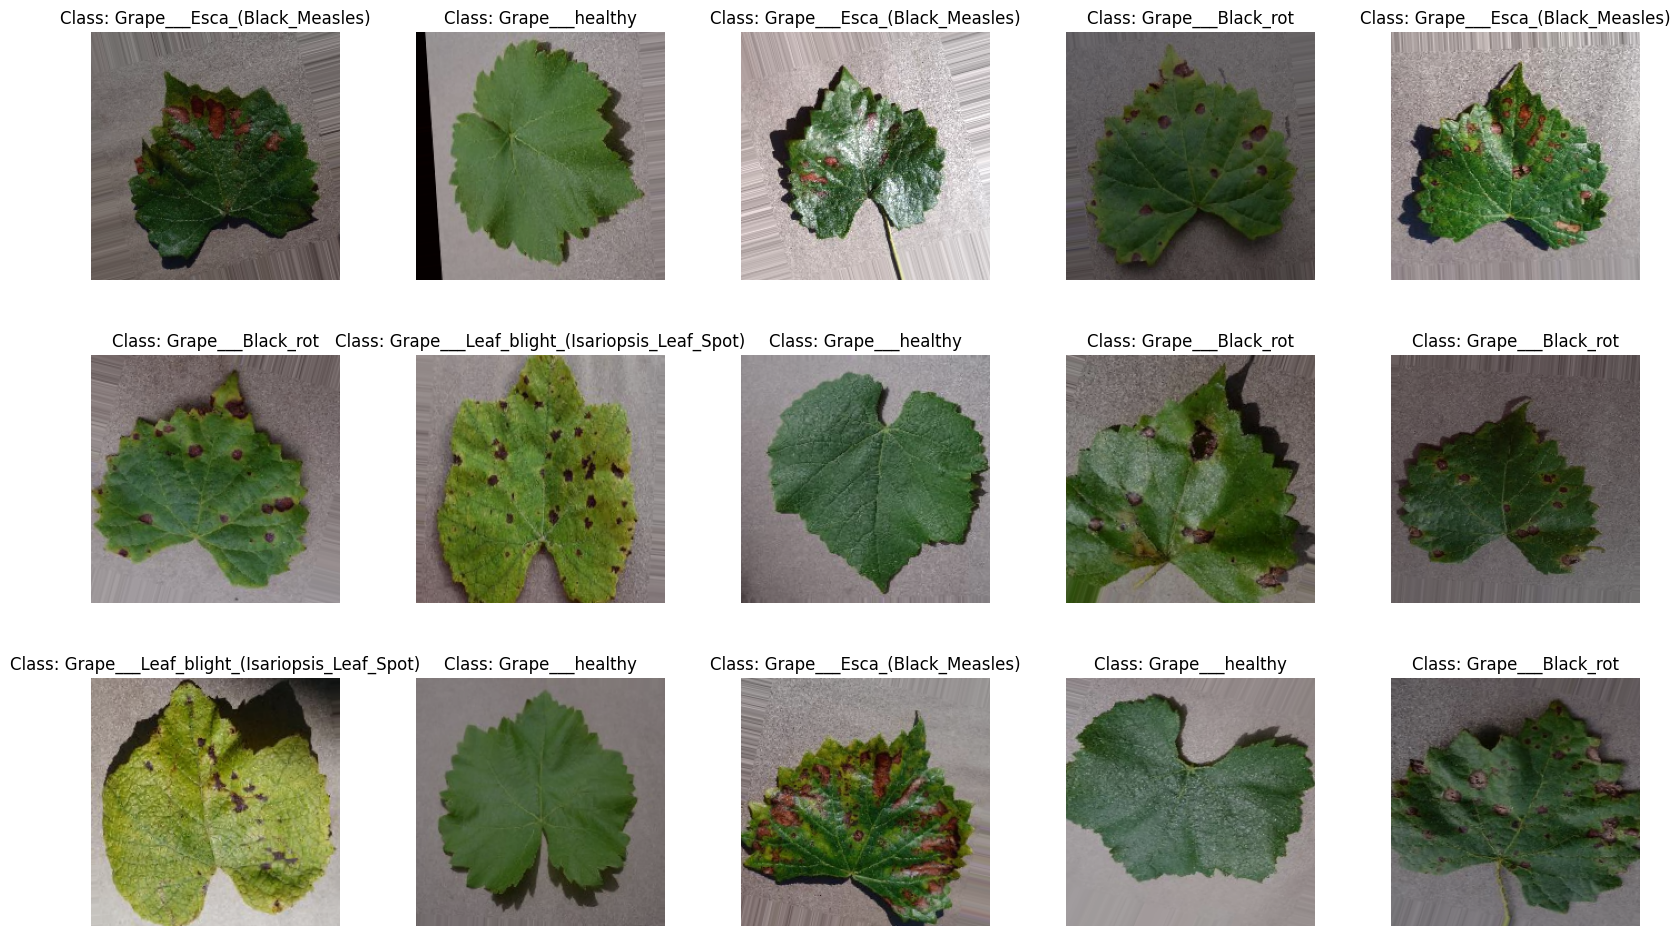

In [ ]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

Using ResNet50 as our base model.

In [ ]:
img_size = 224
base_model = ResNet50(include_top = False,
                      weights = 'imagenet',
                      input_shape = (img_size,img_size,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
for layer in base_model.layers[:-8]:
    layer.trainable = False

# for layer in base_model.layers[-26:]:
#     layer.trainable = True

# base_model.summary()

In [ ]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 4,466,692 (17.04 MB)

 Non-trainable params: 20,172,160 (76.95 MB)

In [ ]:
model_name = "grape_disease_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

try:
    history = model.fit(train_generator,
                        epochs=10,
                        validation_data=val_generator,
                        callbacks=[checkpoint, earlystopping])
except KeyboardInterrupt:
    print("\nTraining Stopped")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4565 - loss: 1.1768
Epoch 1: val_loss improved from inf to 1.84609, saving model to grape_disease_model.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 1633s 8s/step - accuracy: 0.4570 - loss: 1.1759 - val_accuracy: 0.2384 - val_loss: 1.8461
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6849 - loss: 0.7542
Epoch 2: val_loss improved from 1.84609 to 1.23944, saving model to grape_disease_model.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 1645s 9s/step - accuracy: 0.6850 - loss: 0.7539 - val_accuracy: 0.4806 - val_loss: 1.2394
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7523 - loss: 0.5962
Epoch 3: val_loss improved from 1.23944 to 0.52765, saving model to grape_disease_model.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 1641s 9s/step - accuracy: 0.7523 - loss: 0.5962 - val_accuracy: 0.8022 - val_loss: 0.5276
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7614 - loss: 0.5773
Epoch 4: val_loss did not improve fr

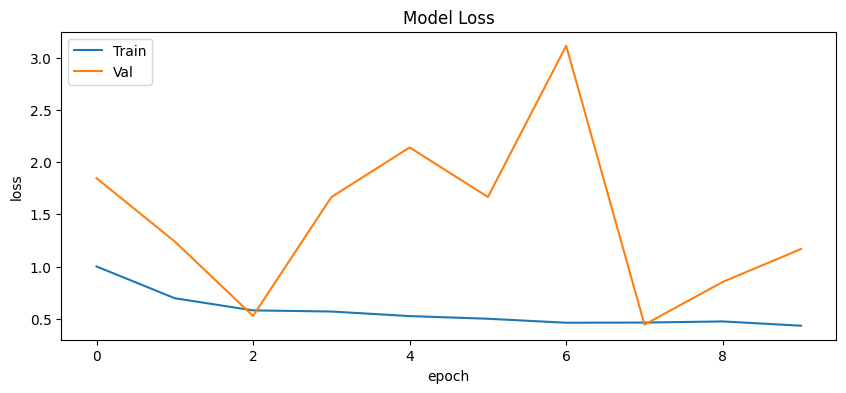

In [ ]:
my_model = tf.keras.models.load_model("grape_disease_model.keras")

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')



In [ ]:
y_test = test_generator.classes
y_pred = my_model.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 379s 7s/step


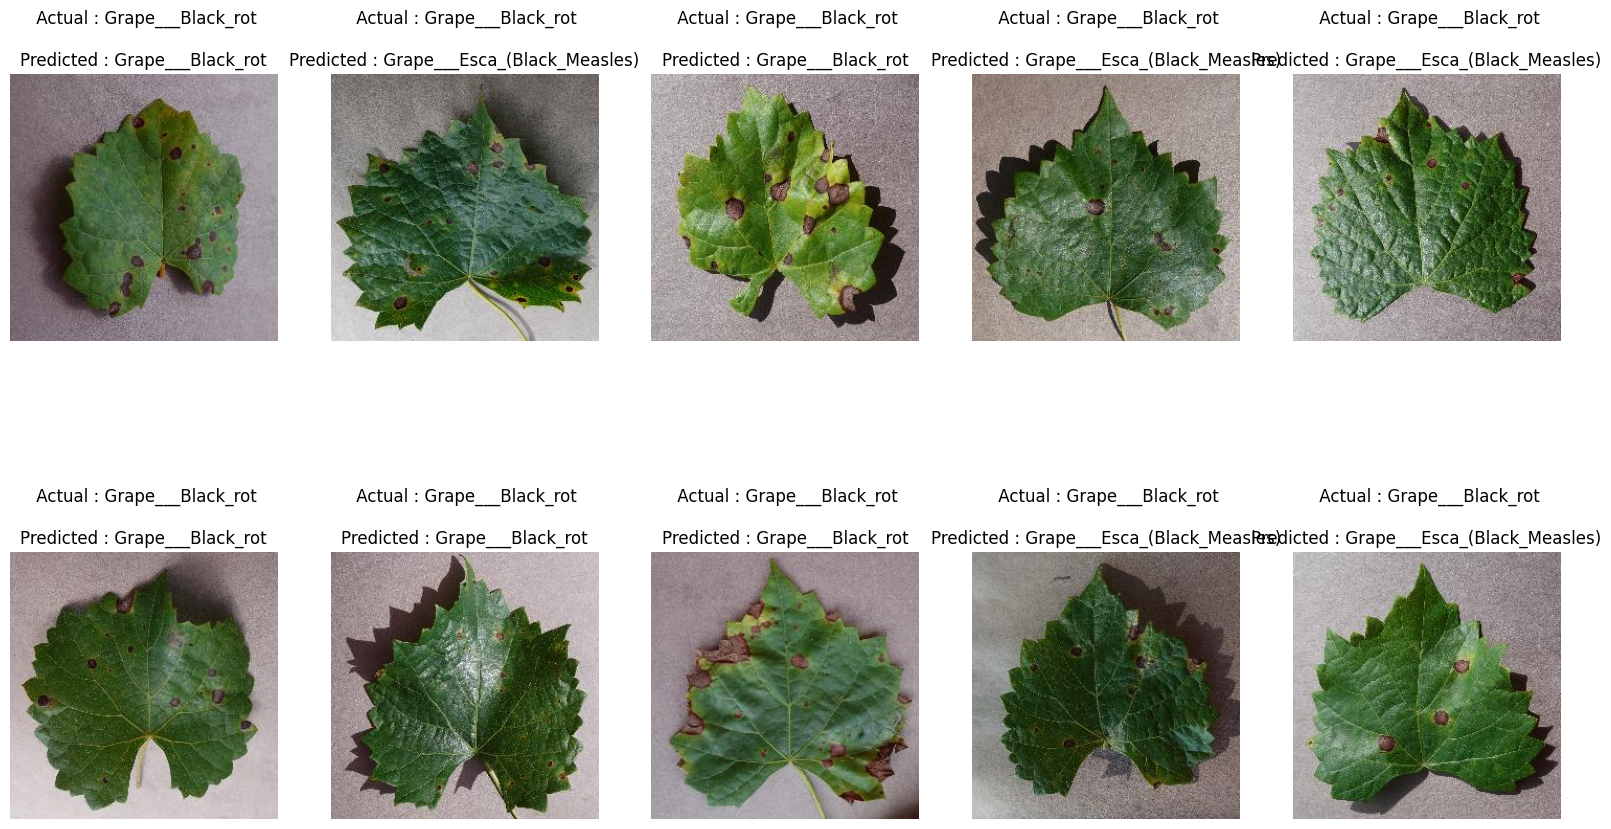

In [ ]:
class_labels = list(test_generator.class_indices.keys())

for i in range(10):
    plt.rcParams['figure.figsize'] = (20, 30)
    img = plt.imread(test_generator.filepaths[i])
    pred_label = y_pred[i]
    actual_label = y_test[i]

    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(f" Actual : {class_labels[actual_label]}\n\nPredicted : {class_labels[pred_label]}")
    plt.axis('off')

plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score


print(f"Accuracy is: {accuracy_score(y_test, y_pred)*100}%\n")
print(classification_report(y_test,y_pred,target_names = labels))

Accuracy is: 78.78116343490305%

                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.91      0.41      0.57       472
              Grape___Esca_(Black_Measles)       0.63      0.91      0.74       480
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.81      0.95      0.87       430
                           Grape___healthy       0.98      0.91      0.94       423

                                  accuracy                           0.79      1805
                                 macro avg       0.83      0.79      0.78      1805
                              weighted avg       0.83      0.79      0.77      1805



Final Accuracy = 79.0027%